In [1]:

import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

/Users/deeppatel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def load_and_preprocess_data(directory, label):
    texts = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                # Remove punctuation and numbers
                text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
                text = re.sub(r'\d+', '', text)  # Remove numbers
                texts.append(text)
                labels.append(label)
    return texts, labels

In [3]:
pos_texts, pos_labels = load_and_preprocess_data('../Data/pos', 1)  # y = 1 for positive reviews
neg_texts, neg_labels = load_and_preprocess_data('../Data/neg', -1)  # y = -1 for negative reviews

# Combine the data
texts = pos_texts + neg_texts
labels = pos_labels + neg_labels

In [4]:
train_texts = texts[:700] + texts[1000:1700]
train_labels = labels[:700] + labels[1000:1700]
test_texts = texts[700:1000] + texts[1700:2000]
test_labels = labels[700:1000] + labels[1700:2000]

In [5]:
def count_unique_words(text_series):
    all_text = ' '.join(text_series)
    unique_words = set(all_text.split())
    return len(unique_words)

print(count_unique_words(texts))

47037


In [13]:
print(texts)

['assume nothing  \nthe phrase is perhaps one of the most used of the s  as first impressions and rumors are hardly ever what they seem to be  \nthe phrase especially goes for oscar novak  an architect who is the main focus of three to tango  a delightful  funny romantic comedy about assumptions and being yourself  \nnovak  matthew perry   a shy  clumsy  chicago based architect  along with openly gay partner  peter steinberg  oliver platt   fights for projects day in and day out  \none of these is the job of restoring a popular building for charles newman  dylan mcdermott   a rich  wellknown businessman  \ncharles immediately takes a liking to oscar  as he enjoys his personality and sense of humor  \nseeing oscar as someone he could trust  charles asks him to watch his girlfriend  an unpredictable  adventurous girl named amy post  neve campbell   who makes a living by blowing glass  \ncharles wants to know who she talks to  what she does  and where she goes  \nthe point  \nto make sure

In [6]:
review_lengths = [len(sequence) for sequence in texts]

# Calculate the average length and standard deviation of review lengths
average_length = np.mean(review_lengths)
std_dev_length = np.std(review_lengths)
print("Average Review Length:", average_length)
print("Standard Deviation of Review Lengths:", std_dev_length)

Average Review Length: 3760.7535
Standard Deviation of Review Lengths: 1657.0358272342062


Text(0, 0.5, 'Frequency')

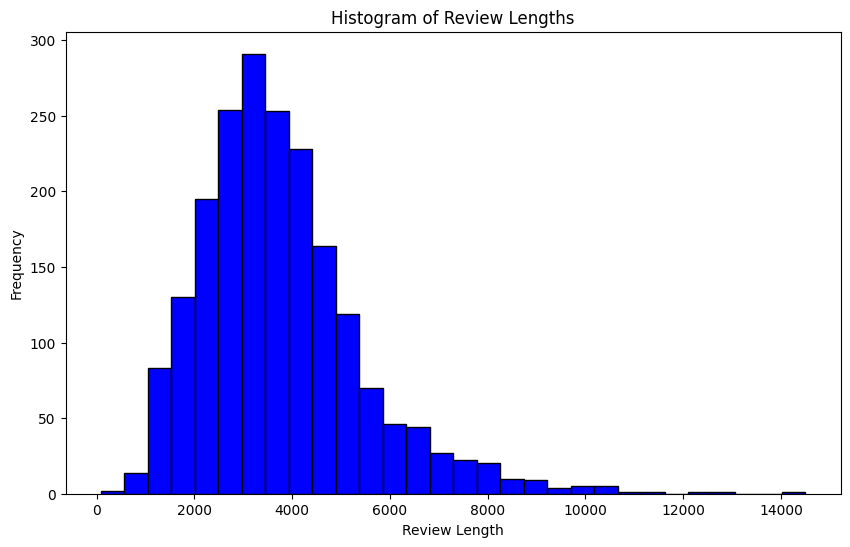

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Instantiate the tokenizer
tokenizer = Tokenizer(num_words=10000)  # Considering the top 10000 most frequent words
all_texts = pos_texts + neg_texts  # Assuming pos_texts and neg_texts are your data lists

# Fit the tokenizer on the data
tokenizer.fit_on_texts(all_texts)
# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(all_texts)
word_index = tokenizer.word_index
print("Word Index:", {k: word_index[k] for k in list(word_index)[:10]})  # Print the first 10 items
print(len(word_index))

Word Index: {'the': 1, 'a': 2, 'and': 3, 'of': 4, 'to': 5, 'is': 6, 'in': 7, 'that': 8, 'it': 9, 'as': 10}
46737


In [9]:
L = np.percentile(review_lengths, 70)
print("Review length L such that 70% of the reviews are shorter than this length:", L)

Review length L such that 70% of the reviews are shorter than this length: 4304.5


In [10]:
L = int(L)
processed_sequences = pad_sequences(sequences, maxlen=L, padding='post', truncating='post')
print("Shape of processed data:", processed_sequences.shape)
print("Example of processed sequence:", processed_sequences[0])

Shape of processed data: (2000, 4304)
Example of processed sequence: [2500  181    1 ...    0    0    0]


In [11]:
model = Sequential()

model.add(Embedding(input_dim=5000, output_dim=32, input_length=L))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()
model.fit(train_texts, train_labels, epochs=10, batch_size=32, validation_split=0.2)

/Users/deeppatel/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

ValueError: Argument `validation_split` is only supported for tensors or NumPy arrays.Found incompatible type in the input: [<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]

In [ ]:

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences
max_length = max(len(x) for x in train_sequences)  # You might choose a different strategy for setting max_length

train_data = pad_sequences(train_sequences, maxlen=max_length)
test_data = pad_sequences(test_sequences, maxlen=max_length)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


In [ ]:
all_texts = train_texts + test_texts
tokenizer.fit_on_texts(all_texts)

# Count the number of unique words
num_unique_words = len(tokenizer.word_index)
print("Number of unique words:", num_unique_words)

Number of unique words: 46737
